<https://www.kaggle.com/ash316/eda-to-prediction-dietanic>

## 1. Exploratory Data Analysis (EDA)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("../input/titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


자연스럽게 결측값 check

- Age, Cabin, Embarked

In [4]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

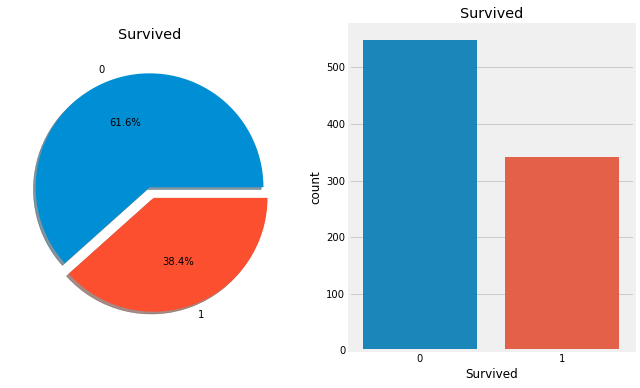

In [8]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
data["Survived"].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%",
                                        ax=ax[0], shadow=True)
ax[0].set_ylabel('')
ax[0].set_title("Survived")

sns.countplot("Survived", data=data, ax=ax[1])
ax[1].set_title("Survived")

plt.show()

features 분류

1. 범주형 자료, Categorical Features (Nominal Variables)
    - Sex, Embarked
2. 순서형 자료, Ordinal Features
    - Pclass
3. 연속형 자료, Continous Features
    - Age

### Analysing The Features

Sex -> Categorical

In [9]:
data.groupby(["Sex", "Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

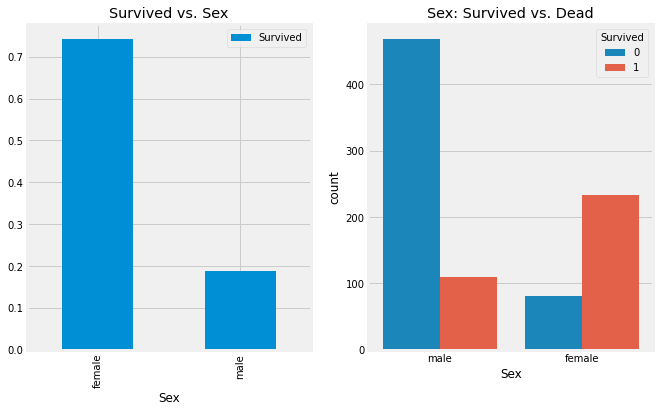

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
data[["Sex", "Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived vs. Sex")

sns.countplot("Sex", hue="Survived", data=data, ax=ax[1])
ax[1].set_title("Sex: Survived vs. Dead")

plt.show()

첫번째 링크처럼 여성의 생존률이 높았다.

Pclass -> Ordinal

In [11]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


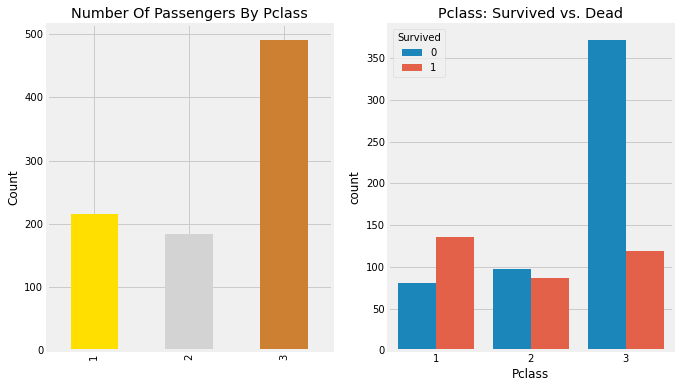

In [12]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
data["Pclass"].value_counts().plot.bar(color=["#CD7F32", "#FFDF00", "#D3D3D3"], ax=ax[0])
ax[0].set_ylabel("Count")
ax[0].set_title("Number Of Passengers By Pclass")

sns.countplot("Pclass", hue="Survived", data=data, ax=ax[1])
ax[1].set_title("Pclass: Survived vs. Dead")

plt.show()

말 참 단호하게 하시네. 슬프게도 class가 낮을수록 생존률이 높았다.

In [15]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap="summer_r")

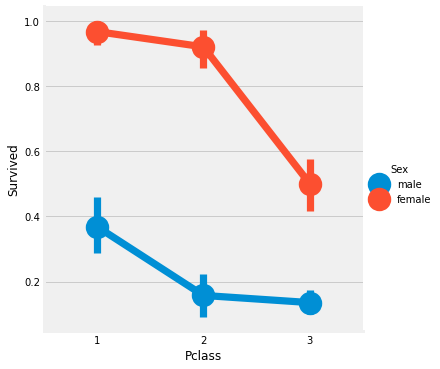

In [16]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=data)
plt.show()

- 확실히 여성의 생존률이 높다.
- Factorplot이 factor형 변수를 잘 나눠서 보기 편하다.

Age -> Countinous

In [17]:
print("Oldset Passenger was of: {} Years".format(data["Age"].max()),
     "Youngest Passenger was of: {} Years".format(data["Age"].min()),
     "Average Age on the ship: {:.2f} Years".format(data["Age"].mean()), sep="\n")

Oldset Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.70 Years


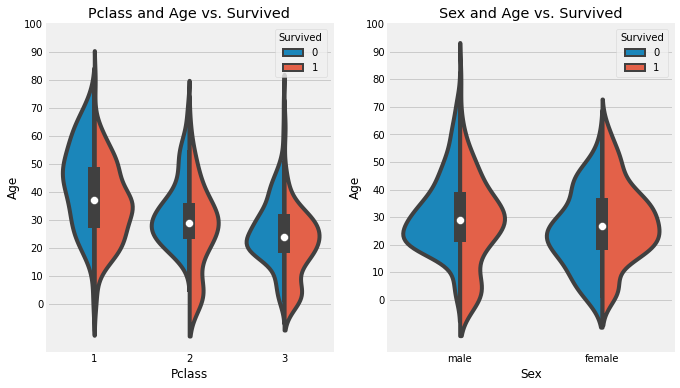

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_yticks(range(0, 110, 10))
ax[0].set_title("Pclass and Age vs. Survived")

sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_yticks(range(0, 110, 10))
ax[1].set_title("Sex and Age vs. Survived")

plt.show()

시각화를 진행하고 뽑아낼 수 있는 정보란 정보는 다 뽑아내야 한다.

- 전반적으로 나이가 어릴수록 일정 수준 이상의 생존률을 유지한다.
- Pclass가 높을수록 (특히 1 class에 대해선) 나이에 영향을 크게 받지 않고 생존률이 고르다.
- 앞선 것들과는 다르게 class가 높을수록, 그리고 나이가 많을수록 생존하지 못한 비율 또한 큰 폭을 유지한다.

Age feature는 결측값이 많았다.(177)<br />
결측값을 제어해야 하는데, 그냥 평균값을 주기에는 원래 값과 편차가 심할 수 있다.<br />
그러니 나머지 data를 initial로 grouping해서 initial 평균으로 결측값을 제거하자.

In [5]:
data["Initial"] = 0
for i in data:
    data["Initial"] = data.Name.str.extract("([A-Za-z]+)\.")

In [6]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap="summer_r")

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [7]:
data['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess',
                         'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don'],
                        ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other',
                         'Other', 'Other', 'Mr', 'Mr', 'Mr'], inplace=True)

In [8]:
data.groupby("Initial")["Age"].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [9]:
data.loc[(data.Age.isnull()) & (data.Initial == "Mr"), "Age"] = 33
data.loc[(data.Age.isnull()) & (data.Initial == "Mrs"), "Age"] = 36
data.loc[(data.Age.isnull()) & (data.Initial == "Master"), "Age"] = 5
data.loc[(data.Age.isnull()) & (data.Initial == "Miss"), "Age"] = 22
data.loc[(data.Age.isnull()) & (data.Initial == "Other"), "Age"] = 46

In [10]:
data.Age.isnull().any()

False

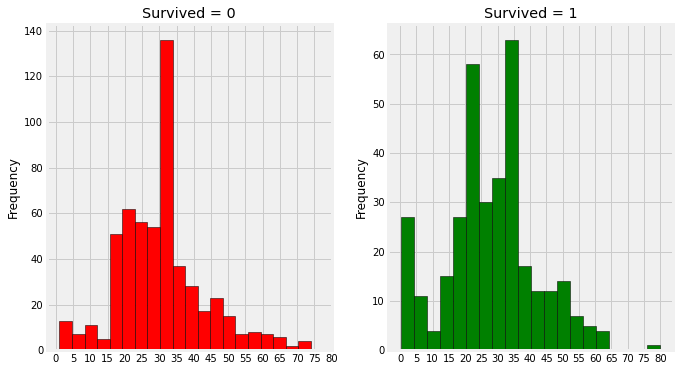

In [29]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
data[data["Survived"] == 0].Age.plot.hist(ax=ax[0], bins=20, edgecolor="black", color="red")
ax[0].set_xticks(range(0, 85, 5))
ax[0].set_title("Survived = 0")

data[data["Survived"] == 1].Age.plot.hist(ax=ax[1], bins=20, edgecolor="black", color="green")
ax[1].set_xticks(range(0, 85, 5))
ax[1].set_title("Survived = 1")

plt.show()

중장년층 사람들이 다른 사람들을 많이 살렸다.?

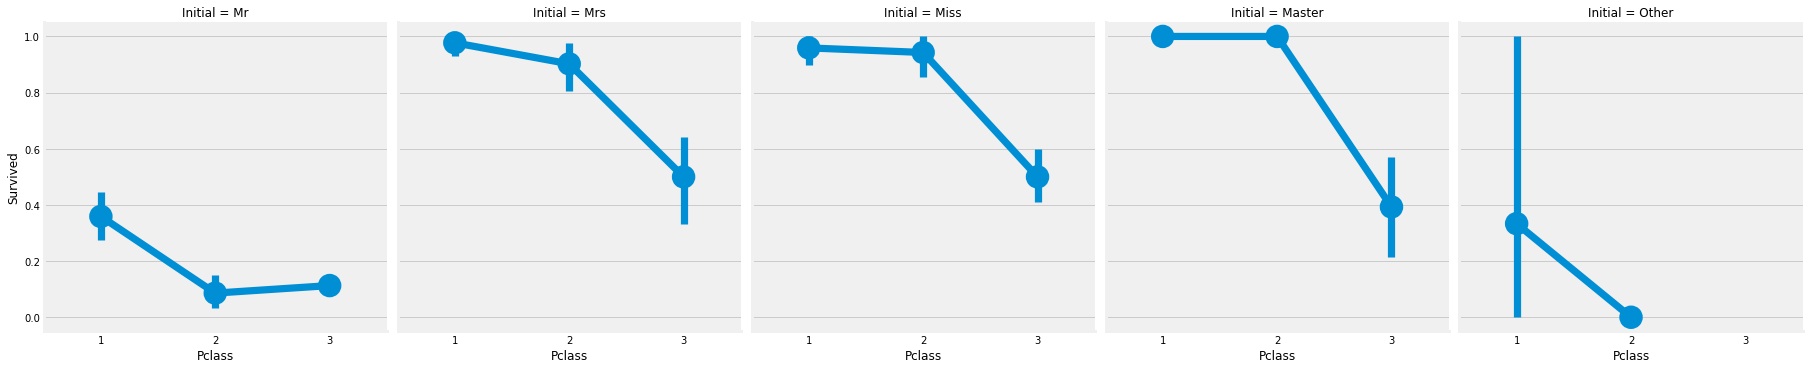

In [32]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data)
plt.show()

hue option이 더 나아보이는데, 내부 문제로 같이 안 그려준다.

Embarked -> Categorical

In [33]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap="summer_r")

표값에 따른 생존률

<Figure size 360x216 with 0 Axes>

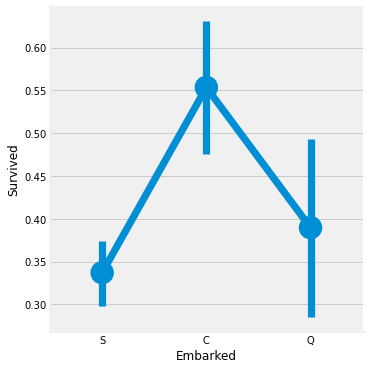

In [35]:
fig = plt.gcf()
sns.factorplot("Embarked", "Survived", data=data)
fig.set_size_inches(5, 3)
plt.show()

Embarked C가 생존률이 높다.

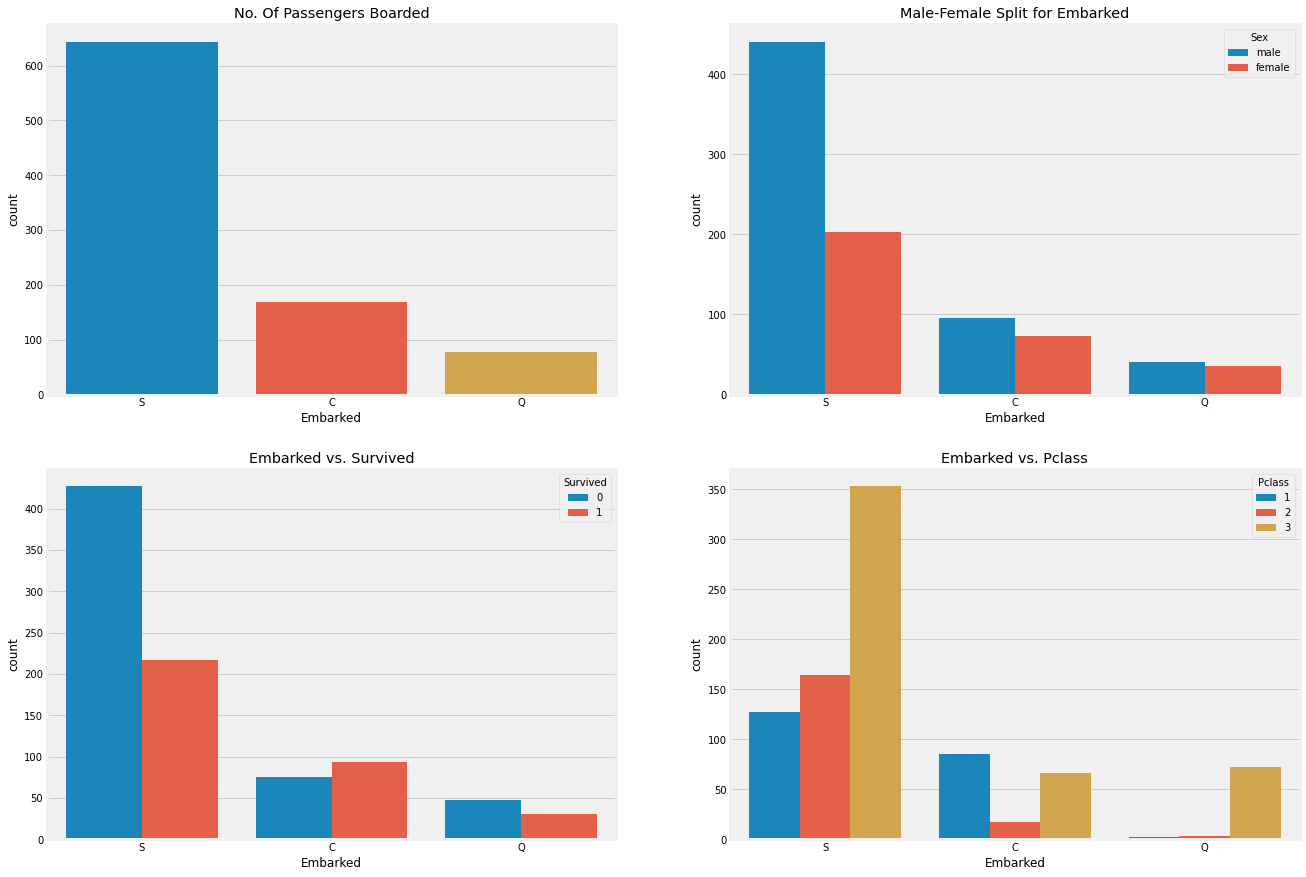

In [36]:
_, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot("Embarked", data=data, ax=ax[0, 0])
ax[0, 0].set_title("No. Of Passengers Boarded")

sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
ax[0, 1].set_title("Male-Female Split for Embarked")

sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
ax[1, 0].set_title("Embarked vs. Survived")

sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs. Pclass")

plt.show()

S가 사람도 많은데, 생존률도 높고 (전반적인 Pclass의 사람 수도 많고)<br />
뭐랄까 너무 정규분포나 결합분포를 잘 따르는 느낌이라 더 보고 싶은 게 없달까.

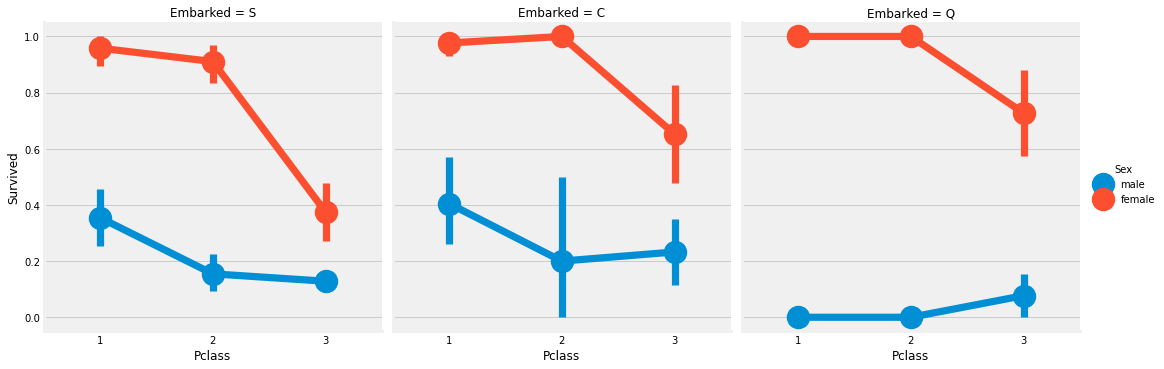

In [37]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

여성의 생존률이 높은 건 사실, Embarked가 Q였을 때 남성 생존률이 굉장히 낮다.

추가적으로 Embarked도 결측값이 존재했다. 이를 없애야 한다.

In [11]:
data["Embarked"].fillna("S", inplace=True)

In [12]:
data.Embarked.isnull().any()

False

SibSip -> Discrete

In [40]:
pd.crosstab([data.SibSp], data.Survived).style.background_gradient(cmap="summer_r")

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


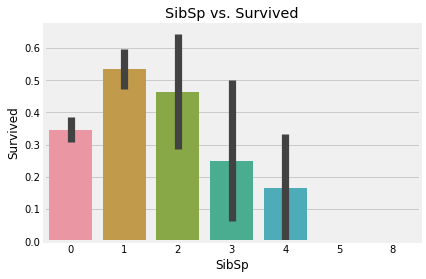

In [78]:
sns.barplot("SibSp", "Survived", data=data)
plt.title("SibSp vs. Survived")
plt.show()

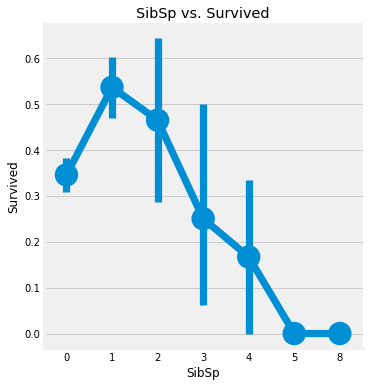

In [79]:
sns.factorplot("SibSp", "Survived", data=data)
plt.title("SibSp vs. Survived")
plt.show()

In [80]:
pd.crosstab(data.SibSp, data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


가족 구성원 수가 많을수록 사망률은 크다. 가족을 구하기 위해 위험을 감수했겠지만, 그것보다 가족이 많을수록 낮은 class를 이용했기에 더 사망률이 높은 것으로 보인다고 한다.

Parch

In [81]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


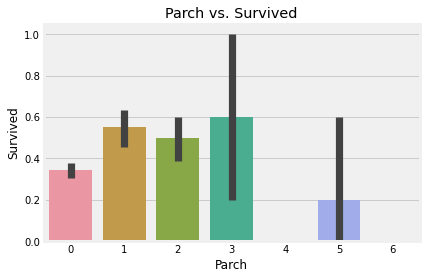

In [82]:
sns.barplot("Parch", "Survived", data=data)
plt.title("Parch vs. Survived")
plt.show()

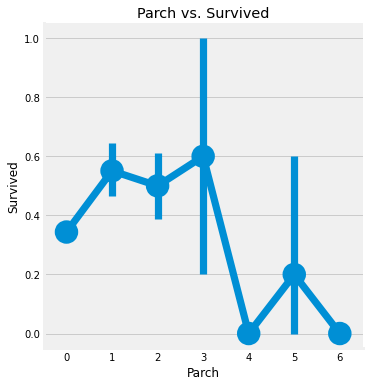

In [83]:
sns.factorplot("Parch", "Survived", data=data)
plt.title("Parch vs. Survived")
plt.show()

어쩌면 당연하게도 가족 구성원 수가 적을수록 생존률이 높았다고 보여진다.

Fare -> Continous

In [84]:
print("Highest Fare was: {}".format(data["Fare"].max()),
     "Lower Fare was: {}".format(data["Fare"].min()),
     "Average Fare was: {:.2f}".format(data["Fare"].mean()), sep="\n")

Highest Fare was: 512.3292
Lower Fare was: 0.0
Average Fare was: 32.20


이용권이 있었던 건가, 무료로 탑승한 유형이 있네.

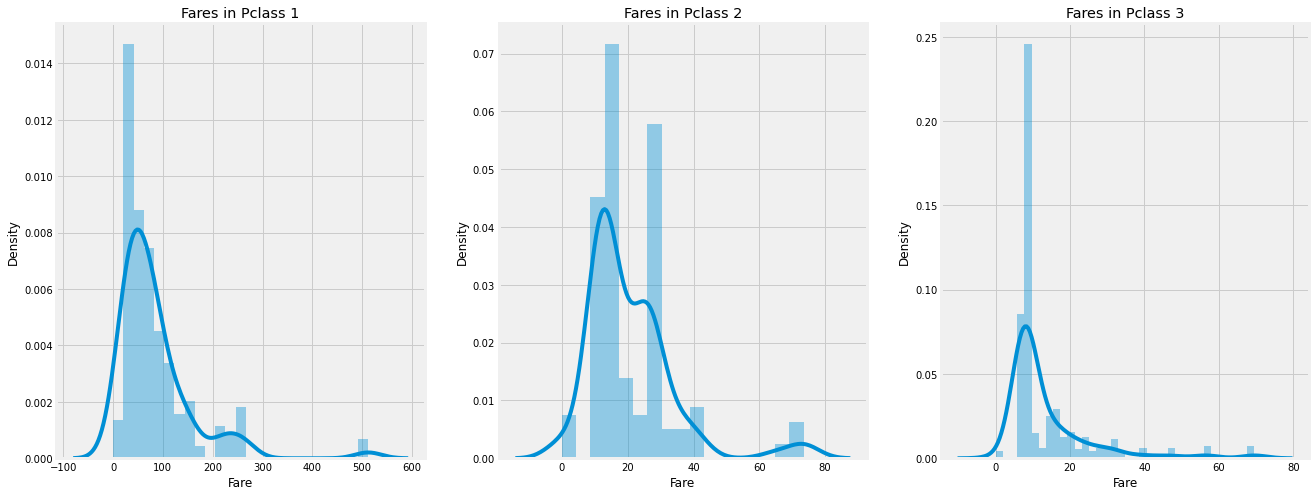

In [85]:
_, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.distplot(data[data["Pclass"] == 1].Fare, ax=ax[0])
ax[0].set_title("Fares in Pclass 1")

sns.distplot(data[data["Pclass"] == 2].Fare, ax=ax[1])
ax[1].set_title("Fares in Pclass 2")

sns.distplot(data[data["Pclass"] == 3].Fare, ax=ax[2])
ax[2].set_title("Fares in Pclass 3")

plt.show()

Pclass 1에 저렇게 비싼 건 대체 뭐지. 그리고 Pclass 2랑 3의 bins 차이가 안 나는데 그럼 서비스도 크게 차이가 안 나는 건가.

### Correlation Between The Features

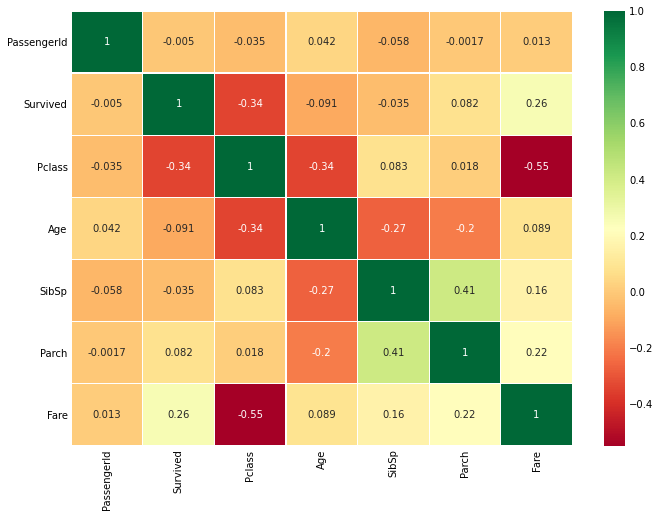

In [87]:
fig = plt.gcf()
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2)
fig.set_size_inches(10, 8)
plt.show()

## 2. Feature Engineering and Data Cleaning

- 쉽게 말해 모든 전처리 과정

In [13]:
data["Age_band"] = 0
data.loc[data["Age"] <= 16, "Age_band"] = 0
data.loc[(data["Age"] > 16) & (data["Age"] <= 32), "Age_band"] = 1
data.loc[(data["Age"] > 32) & (data["Age"] <= 48), "Age_band"] = 2
data.loc[(data["Age"] > 48) & (data["Age"] <= 64), "Age_band"] = 3
data.loc[data["Age"] > 64, "Age_band"] = 4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [14]:
data["Age_band"].value_counts().to_frame().style.background_gradient(cmap="summer_r")

,Age_band
1,382
2,325
0,104
3,69
4,11


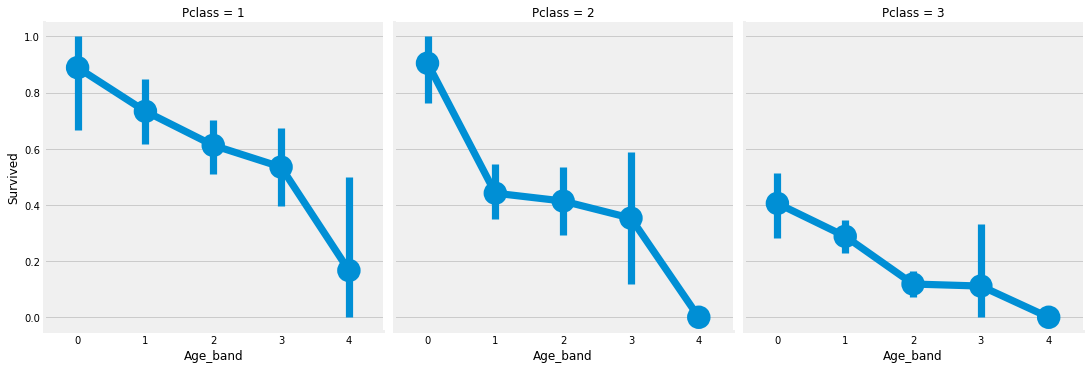

In [90]:
sns.factorplot("Age_band", "Survived", data=data, col="Pclass")
plt.show()

Family_Size and Alone

In [15]:
data["Family_Size"] = 0
data["Family_Size"] = data["Parch"] + data["SibSp"]
data["Alone"] = 0
data.loc[data.Family_Size == 0, "Alone"] = 1

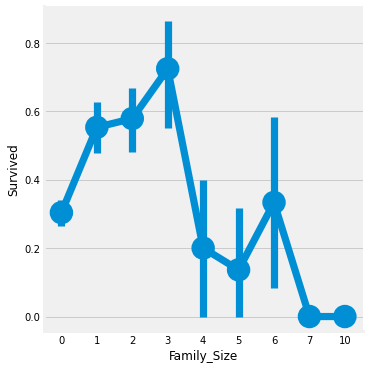

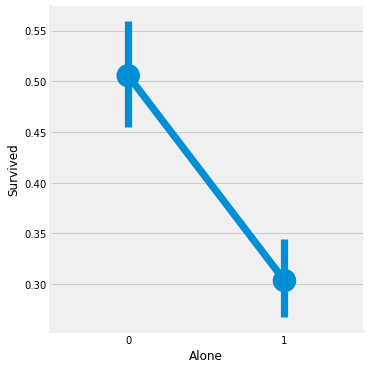

In [100]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.factorplot("Family_Size", "Survived", data=data, ax=ax[0])
# ax[0].set_title("Family_Size vs. Survived")

sns.factorplot("Alone", "Survived", data=data, ax=ax[1])
# ax[1].set_title("Alone vs. Survived")

plt.close(0)
plt.close(1)
plt.show()

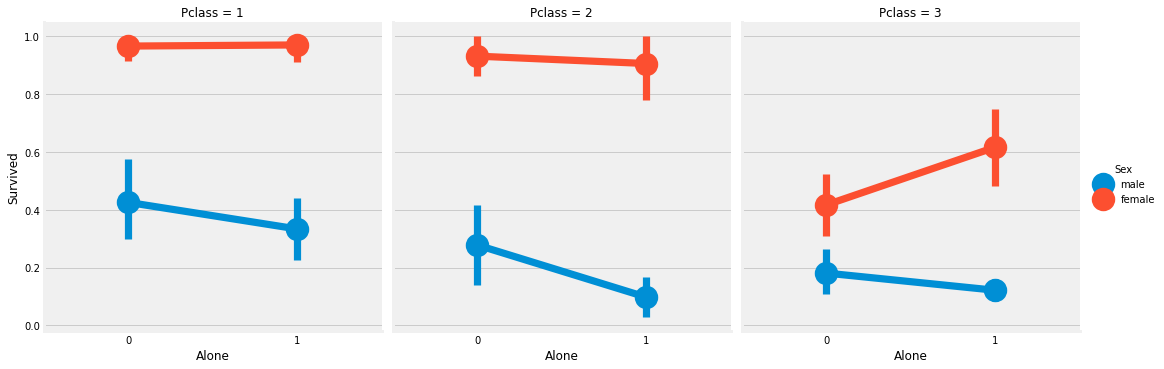

In [101]:
sns.factorplot("Alone", "Survived", data=data, hue="Sex", col="Pclass")
plt.show()

Fare_range

시각화에 좀 더 유리하고자 그리고 특정 범위에 많이 분포된 연속형 자료를 순서형 자료로 변환시킨 게 많다.

In [16]:
data["Fare_Range"] = pd.qcut(data["Fare"], 4)
data.groupby(["Fare_Range"])["Survived"].mean().to_frame().style.background_gradient(cmap="summer_r")

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [17]:
data["Fare_cat"] = 0
data.loc[data["Fare"] <= 7.91, "Fare_cat"] = 0
data.loc[(data["Fare"] > 7.91) & (data["Fare"] <= 14.454), "Fare_cat"] = 1
data.loc[(data["Fare"] > 14.454) & (data["Fare"] <= 31), "Fare_cat"] = 2
data.loc[(data["Fare"] > 31) & (data["Fare"] <= 513), "Fare_cat"] = 3

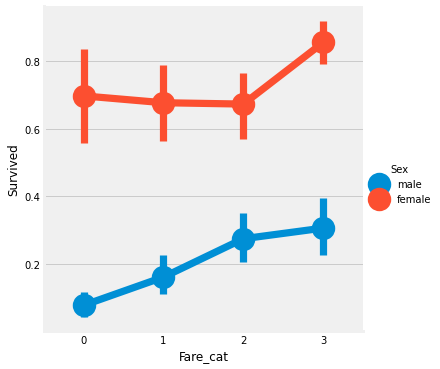

In [18]:
sns.factorplot("Fare_cat", "Survived", data=data, hue="Sex")
plt.show()

전체적인 fare에 대해서 여성보다 남성이 각 fare에 대해서 차이가 있다고 보여지는데 왜 그런 거지. 아. 거의 중세지. 여성이 많이 움직일 때가 아니었구나. 특히나 생존률과 결합했을 때라서 남성의 생존률이 더 낮게 나왔구나.

string 범주 변수를 model에서 이용하기 위해 factor형으로 나아가 tokenize할 생각인 듯하다.

In [19]:
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4],
                        inplace=True)

In [20]:
data.drop(["Name", "Age", "Ticket", "Fare", "Cabin", "Fare_Range", "PassengerId"],
          axis=1, inplace=True)

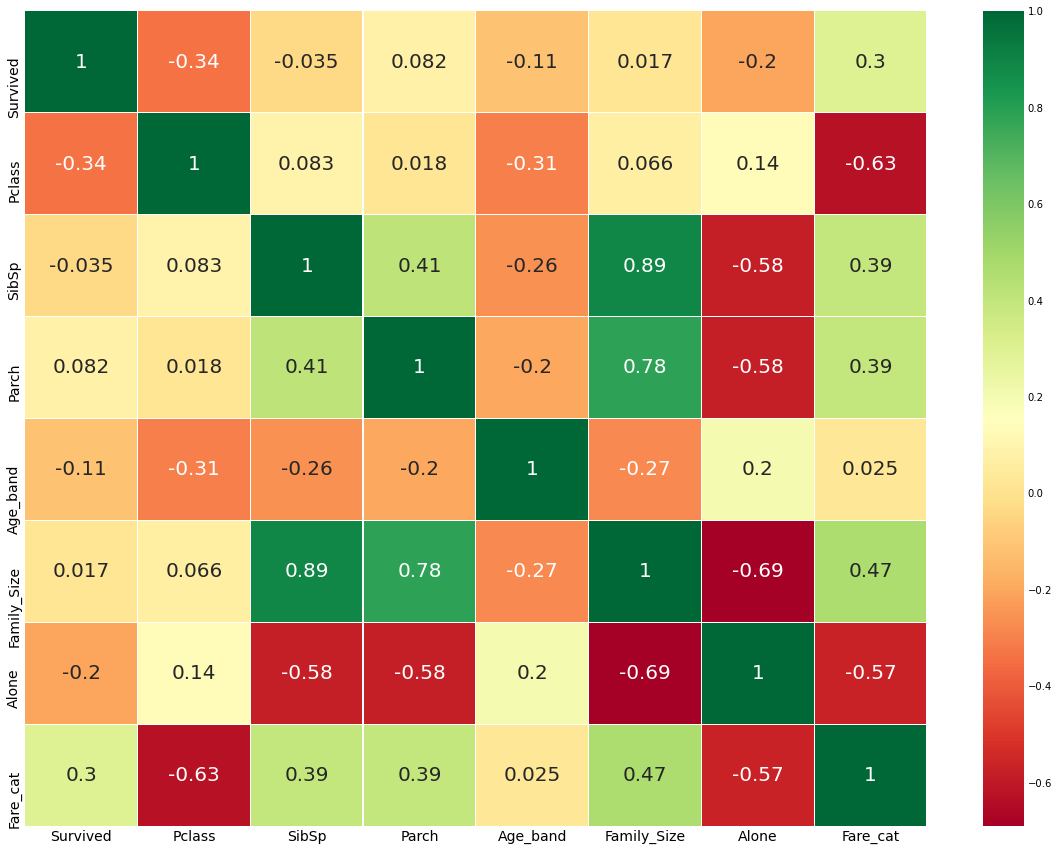

In [107]:
plt.figure(figsize=(18, 15))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2,
            annot_kws={"size": 20})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### 3. Predictive Modeling

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [22]:
train, test = train_test_split(data, test_size=0.3, random_state=0,
                               stratify=data["Survived"])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]

X = data[data.columns[1:]]
Y = data["Survived"]

#### rbf-SVM (Radial Support Vector Machine)

In [113]:
model = svm.SVC(kernel="rbf", C=1, gamma=0.1)
model.fit(train_X, train_Y)
pred1 = model.predict(test_X)
print("Accuracy for rbf SVM is", metrics.accuracy_score(pred1, test_Y))

Accuracy for rbf SVM is 0.835820895522388


#### linear-SVM (Linear Support Vector Machine)

In [114]:
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(train_X, train_Y)
pred2 = model.predict(test_X)
print("Accuracy for linear SVM is", metrics.accuracy_score(pred2, test_Y))

Accuracy for linear SVM is 0.8171641791044776


#### Logistic Regression

In [115]:
model = LogisticRegression()
model.fit(train_X, train_Y)
pred3 = model.predict(test_X)
print("Accuracy for the Logistic Regression is",
      metrics.accuracy_score(pred3, test_Y))

Accuracy for the Logistic Regression is 0.8134328358208955


#### Decision Tree

In [116]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)
pred4 = model.predict(test_X)
print("The accuracy of the Decision Tree is", metrics.accuracy_score(pred4, test_Y))

The accuracy of the Decision Tree is 0.8059701492537313


#### KNN (K-Nearset Neighbors)

default: 3으로 기억

In [118]:
model = KNeighborsClassifier()
model.fit(train_X, train_Y)
pred5 = model.predict(test_X)
print("The accuracy of the KNN is", metrics.accuracy_score(pred5, test_Y))

The accuracy of the KNN is 0.832089552238806


In [119]:
prediction = pd.Series()
for i in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X, train_Y)
    p = model.predict(test_X)
    prediction = prediction.append(pd.Series(metrics.accuracy_score(p, test_Y)))

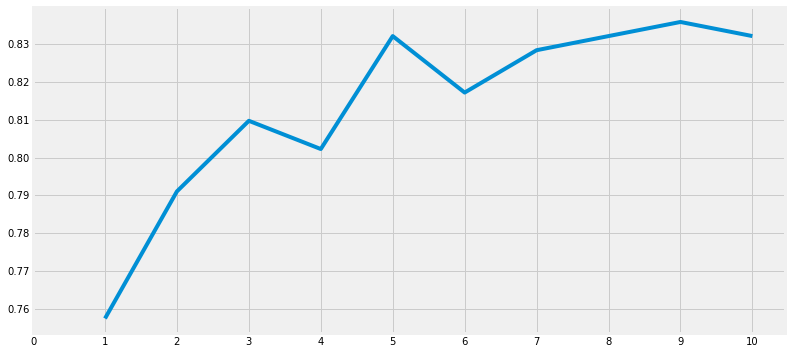

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as 0.835820895522388


In [120]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), prediction)
plt.xticks(range(11))
plt.show()
print("Accuracies for different values of n are: {} with the max value as {}"
     .format(prediction.values, prediction.values.max()))

#### Gaussian Naive Bayes

In [121]:
model = GaussianNB()
model.fit(train_X, train_Y)
pred6 = model.predict(test_X)
print("The accuracy of the NaiveBayes is", metrics.accuracy_score(pred6, test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


#### Random Forests

In [122]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_Y)
pred7 = model.predict(test_X)
print("The accuracy of the Random Forests is", metrics.accuracy_score(pred7, test_Y))

The accuracy of the Random Forests is 0.8171641791044776


단일로는 90%의 정확도를 내는 model이 나오지 않았다. 어쩌면 당연한 결과.

#### Cross Validation

In [23]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [126]:
kfold = KFold(n_splits=10, random_state=22, shuffle=True)
xyz = []
accuracy = []
std = []
classifiers = ["Linear Svm", "Radial Svm", "Logistic Regression", "KNN",
               "Decision Tree", "Naive Bayes", "Random Forest"]
models = [svm.SVC(kernel="linear"), svm.SVC(kernel="rbf"), LogisticRegression(),
         KNeighborsClassifier(n_neighbors=9), DecisionTreeClassifier(),
         GaussianNB(), RandomForestClassifier(n_estimators=100)]

In [127]:
for i in models:
    model = i
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

In [128]:
new_models_df2 = pd.DataFrame({"CV Mean": xyz, "Std": std}, index=classifiers)
new_models_df2

,CV Mean,Std
Linear Svm,0.784607,0.057841
Radial Svm,0.828377,0.057096
Logistic Regression,0.799176,0.040154
KNN,0.808140,0.040287
Decision Tree,0.802497,0.046242
Naive Bayes,0.795843,0.054861
Random Forest,0.818227,0.048971


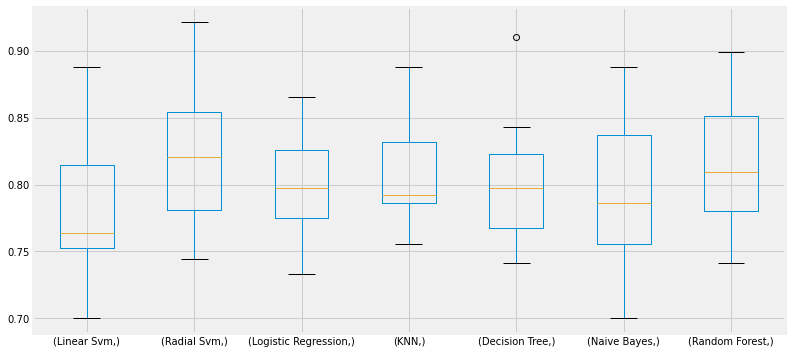

In [129]:
plt.figure(figsize=(12, 6))
pd.DataFrame(accuracy, index=[classifiers]).T.boxplot()
plt.show()

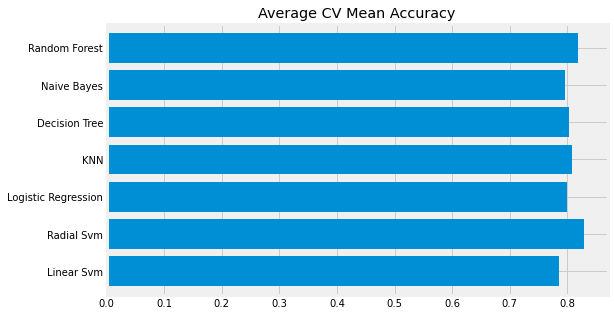

In [130]:
plt.figure(figsize=(8, 5))
new_models_df2["CV Mean"].plot.barh(width=0.8)
plt.title("Average CV Mean Accuracy")
plt.show()

#### Confusion Matrix

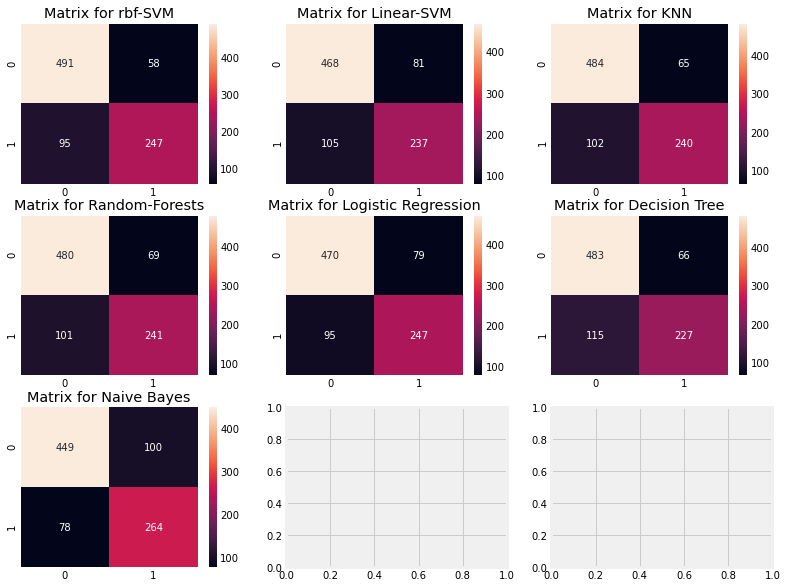

In [132]:
_, ax = plt.subplots(3, 3, figsize=(12, 10))

y_pred = cross_val_predict(svm.SVC(kernel="rbf"), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 0], annot=True, fmt="2.0f")
ax[0, 0].set_title("Matrix for rbf-SVM")

y_pred = cross_val_predict(svm.SVC(kernel="linear"), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 1], annot=True, fmt="2.0f")
ax[0, 1].set_title("Matrix for Linear-SVM")

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 2], annot=True, fmt="2.0f")
ax[0, 2].set_title("Matrix for KNN")

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 0], annot=True, fmt="2.0f")
ax[1, 0].set_title("Matrix for Random-Forests")

y_pred = cross_val_predict(LogisticRegression(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 1], annot=True, fmt="2.0f")
ax[1, 1].set_title("Matrix for Logistic Regression")

y_pred = cross_val_predict(DecisionTreeClassifier(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 2], annot=True, fmt="2.0f")
ax[1, 2].set_title("Matrix for Decision Tree")

y_pred = cross_val_predict(GaussianNB(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[2, 0], annot=True, fmt="2.0f")
ax[2, 0].set_title("Matrix for Naive Bayes")

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

Decision Tree의 정확도가 가장 낮은 것 같다.

#### Hyper-parameter Tuning

- 때에 따라서 전처리만큼 걸릴수도 있는 무시무시한 그것.

SVM

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
C = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ["rbf", "linear"]
hyper = {"kernel": kernel, "C": C, "gamma": gamma}

In [135]:
gd = GridSearchCV(estimator=svm.SVC(), param_grid=hyper, verbose=True)
gd.fit(X, Y)
print(gd.best_score_, gd.best_estimator_, sep="\n")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8282593685267716
SVC(C=0.4, gamma=0.3)


Random Forests

In [26]:
n_estimators = range(100, 1000, 100)
hyper = {"n_estimators": n_estimators}

In [139]:
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid=hyper, verbose=True)
gd.fit(X, Y)
print(gd.best_score_, gd.best_estimator_, sep="\n")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.819327098110602
RandomForestClassifier(n_estimators=300, random_state=0)


#### Ensembling

유명한 3가지 방법으로 각각 시도해보려고 한다.

Voting Classifier

In [27]:
from sklearn.ensemble import VotingClassifier

In [142]:
ensemble_lin_rbf = VotingClassifier(
    estimators=[("KNN", KNeighborsClassifier(n_neighbors=10)),
               ("RBF", svm.SVC(probability=True, kernel="rbf", C=0.5, gamma=0.1)),
               ("RFor", RandomForestClassifier(n_estimators=500, random_state=0)),
               ("LR", LogisticRegression(C=0.05)),
               ("DT", DecisionTreeClassifier(random_state=0)),
               ("NB", GaussianNB()),
               ("svm", svm.SVC(kernel="linear", probability=True))], voting="soft")
ensemble_lin_rbf.fit(train_X, train_Y)
print("The accuracy for ensemble model is {}"
     .format(ensemble_lin_rbf.score(test_X, test_Y)),
     "The cross validated score is {}"
      .format(cross_val_score(ensemble_lin_rbf, X, Y, cv=10, scoring="accuracy").mean()),
     sep="\n")

The accuracy for ensemble model is 0.8246268656716418
The cross validated score is 0.8249188514357053


#### Bagging

In [28]:
from sklearn.ensemble import BaggingClassifier

In [144]:
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),
                          random_state=0, n_estimators=700)
model.fit(train_X, train_Y)
prediction = model.predict(test_X)
print("The accuracy for bagged KNN is:", metrics.accuracy_score(prediction, test_Y),
     "The cross validated score for bagged KNN is",
      cross_val_score(model, X, Y, cv=10, scoring="accuracy").mean(), sep="\n")

The accuracy for bagged KNN is:
0.835820895522388
The cross validated score for bagged KNN is
0.8160424469413232


#### Boosting

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [146]:
ada = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=0.1)
print("The cross validated score for AdaBoost is",
     cross_val_score(ada, X, Y, cv=10, scoring="accuracy").mean())

The cross validated score for AdaBoost is 0.8249188514357055


Stochastic Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [148]:
grad = GradientBoostingClassifier(n_estimators=500, random_state=0, learning_rate=0.1)
print("The cross validated score for Gradient Boosting is",
     cross_val_score(grad, X, Y, cv=10, scoring="accuracy").mean())

The cross validated score for Gradient Boosting is 0.8115230961298376


XGBoost

In [31]:
import xgboost as xg

In [150]:
xgboost = xg.XGBClassifier(n_estimators=900, learning_rate=0.1)
print("The cross validated score for XGBoost is",
     cross_val_score(xgboost, X, Y, cv=10, scoring="accuracy").mean())

[08:23:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:23:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Hyper-parameter tuning for AdaBoost

In [32]:
n_estimators = range(100, 1100, 100)
learn_rate = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
hyper = {"n_estimators": n_estimators, "learning_rate": learn_rate}

In [154]:
gd = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=hyper, verbose=True)
gd.fit(X, Y)
print(gd.best_score_, gd.best_estimator_, sep="\n")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.8293892411022534
AdaBoostClassifier(learning_rate=0.1, n_estimators=100)


#### Confusion Matrix for the Best Model

In [34]:
ada = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=0.05)
result = cross_val_predict(ada, X, Y, cv=10)

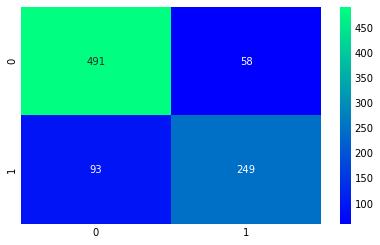

In [35]:
sns.heatmap(confusion_matrix(Y, result), cmap="winter", annot=True, fmt="2.0f")
plt.show()

#### Feature Importance

AttributeError: 'DataFrame' object has no attribute 'coluns'

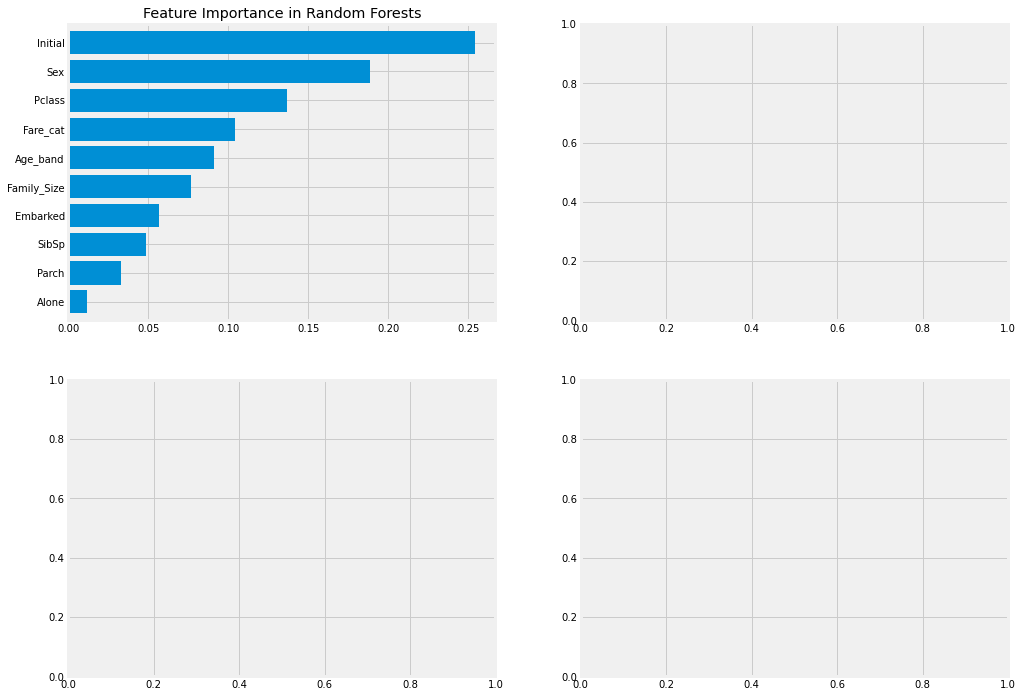

In [36]:
_, ax = plt.subplots(2, 2, figsize=(15, 12))

model = RandomForestClassifier(n_estimators=500, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns).sort_values(
    ascending=True).plot.barh(width=0.8, ax=ax[0, 0])
ax[0, 0].set_title("Feature Importance in Random Forests")

model = AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns).sort_values(
    ascending=True).plot.barh(width=0.8, ax=ax[0, 1], color="#ddff11")
ax[0, 1].set_title("Feature Importance in AdaBoost")


model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns).sort_values(
    ascending=True).plot.barh(width=0.8, ax=ax[1, 0], cmap="RdYlGn_r")
ax[1, 0].set_title("Feature Importance in Gradient Boosting")

model = xg.XGBClassifier(n_estimators=900, learning_rate=0.1)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns).sort_values(
    ascending=True).plot.barh(width=0.8, ax=ax[1, 1], color="#FD0F00")
ax[1, 1].set_title("Feature Importance in XgBoost")

plt.show()